In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
from patsy import dmatrices
from stargazer.stargazer import Stargazer
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns

from mav_analysis.config import dir_config

# Analyzing train delays of the Hungarian Railway system
## A graph-based approach

**authors: Seneca Miller, István Járay**

**course: Data Analysis 2, Coding 1**

**submission date: 2025/01/05**

**program: Central European University**

Todo-list:

storytelling
- data sources
- preprocessing in a nutshell 
  - (creating a preprocessing pipelines collection for the preprocessing steps if time permits)
  - explaining differences between different graphs
- research question 
  - motivation behind explanatory and control variables


coding
- analysis
  - descriptive statistics
  - regressional analysis
    - model comparison
    - selecting final model
- results

# Analysis

Preliminary information:
- The level of observation is each stop on each day
- Every measure is aggregated to this observational level
- Chosen variables:
  - Our main explanatory variable is weighted betweenness (weighted with the daily number of trains traversing that edge)
  - Our dependent variable is the number of daily average delays when arriving to a certain stop
  - Our main control variables are day of week and total throughput (number of incoming and outgoing trains per day)
  - Additional control variables will be added
- We will only do cross-sectional analysis
- We use a multivariate linear regression
- However, christmas is part of our dataset, so a time-trend filter with a simple dummy might be interesting for control.

In [2]:
df = pd.read_parquet(
    dir_config.analysis_data_dir / "daily_vertex_attributes.parquet"
).rename(
    columns={
        "incoming": "num_incoming_trains",
        "outgoing": "num_outgoing_trains",
        "sum_incoming_outgoing": "num_total_trains",
    }
)

In [3]:
# Removing the first and last days
# Since this is a scraped dataset, the first and last days are not complete
df = df[df["date"] != df["date"].min()]
df = df[df["date"] != df["date"].max()]

In [4]:
# convert datetime day of week to english name
df["day_of_week_name"] = (
    df["day_of_week"]
    .map(
        {
            0: "Monday",
            1: "Tuesday",
            2: "Wednesday",
            3: "Thursday",
            4: "Friday",
            5: "Saturday",
            6: "Sunday",
        }
    )
    .astype("category")
)

## Describing the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27715 entries, 0 to 1204
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   stop_id                     27715 non-null  int64         
 1   stop_name                   27715 non-null  object        
 2   stop_lat                    27715 non-null  float64       
 3   stop_lon                    27715 non-null  float64       
 4   num_incoming_edges          27715 non-null  float64       
 5   num_outgoing_edges          27715 non-null  float64       
 6   num_incoming_trains         27715 non-null  float64       
 7   num_outgoing_trains         27715 non-null  float64       
 8   num_total_trains            27715 non-null  float64       
 9   avg_neighboring_delay       15569 non-null  float64       
 10  avg_incoming_delay          16697 non-null  float64       
 11  weighted_betweenness        27715 non-null  float64       
 

In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
stop_id,27715.0,8883.356846,70.0,940.0,1866.0,3841.0,189208.0,26083.935788
stop_lat,27715.0,47.223203,45.834167,46.751389,47.279722,47.693889,48.558333,0.628771
stop_lon,27715.0,19.286846,16.263056,17.921667,19.22294,20.56228,22.796111,1.592337
num_incoming_edges,27715.0,2.79834,1.0,2.0,2.0,3.0,26.0,1.892583
num_outgoing_edges,27715.0,2.79834,1.0,2.0,2.0,3.0,26.0,1.892583
num_incoming_trains,27715.0,23.346599,0.0,7.0,16.0,29.0,358.0,28.633455
num_outgoing_trains,27715.0,23.346599,0.0,7.0,16.0,30.0,376.0,27.098897
num_total_trains,27715.0,46.693199,0.0,14.0,32.0,58.0,734.0,54.53507
avg_neighboring_delay,15569.0,9.292301,0.0,0.281633,0.941392,6.150595,1079.0,28.574554
avg_incoming_delay,16697.0,8.892298,0.0,0.180716,0.557692,3.486364,1439.0,33.61904


In [7]:
# The ratio of the number of observations for the dependent variable
# to the number of total observations
print(
    f"We have observations for the dependent variable for the {(16697 / 27715)*100:.2f}% of the total observations."
)

We have observations for the dependent variable for the 60.25% of the total observations.


**Variables in the focus**
- Explanatory variable:
  - Betweenness and weighted betweenness seems to be heavily skewed to the right, with the minimum involving 0 --> might be problematic 
    - log(1+x) might be useful - depends on the distribution
- The two control variables:
  - the total throughput is also skewed to the right
  - day of week is distributed evenly
- The dependent variable
  - 

**Additional covariates**
- average distance variables - time-invariant
  - distances are calculated for those edges that had at least one train traversing them during the time period
  - the incoming distances are 0 where the node is always the first on any route
  - the outgoing distances are 0 where the node is always the first on any route
  - the total distances are never 0
- average time variables - time invariant
  - 

### Descriptive statistics of the dependent variable

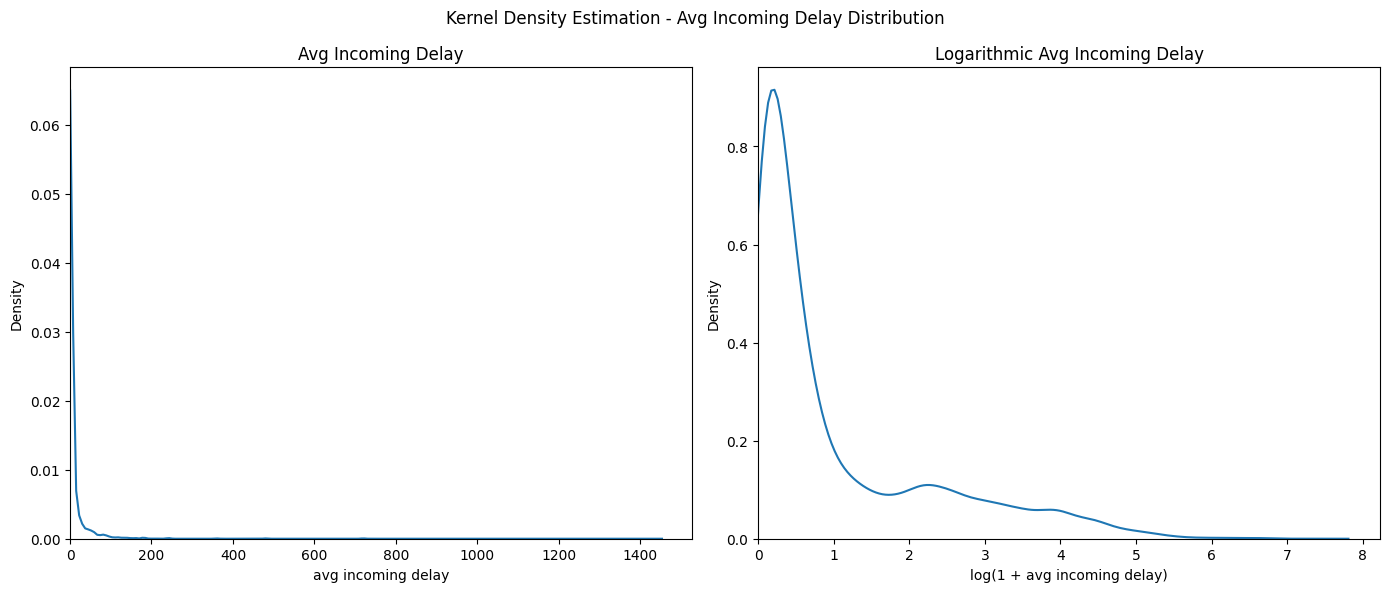

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Kernel Density estimation - avg incoming delay distribution".title())
# KDE plot
sns.kdeplot(df["avg_incoming_delay"].dropna(), ax=axes[0])
axes[0].set_title("Avg Incoming Delay".title())
axes[0].set_xlabel("avg incoming delay")
axes[0].set_xlim(left=0)

# Logarithmic KDE plot
sns.kdeplot(np.log1p((df["avg_incoming_delay"]).dropna()), ax=axes[1])
axes[1].set_title("Logarithmic Avg Incoming Delay".title())
axes[1].set_xlabel("log(1 + avg incoming delay)")
axes[1].set_xlim(left=0)

plt.tight_layout()
plt.savefig(dir_config.graph_dir / "avg_incoming_delay_distribution.png")
plt.show()

In [21]:
df["avg_incoming_delay_is_zero"] = np.where(
    df["avg_incoming_delay"] == 0, "zero", "non-zero"
)
df["avg_incoming_delay_is_zero"].value_counts(normalize=True).round(2)

avg_incoming_delay_is_zero
non-zero    0.97
zero        0.03
Name: proportion, dtype: float64

The daily average of the incoming delays is heavily skewed to the left.

Taking the log(1+x) still yields a strongly left-skewed distribution. The right tail is stronger however

About 97 percent of observations are non-zero

### Descriptive statistics of the explanatory variable

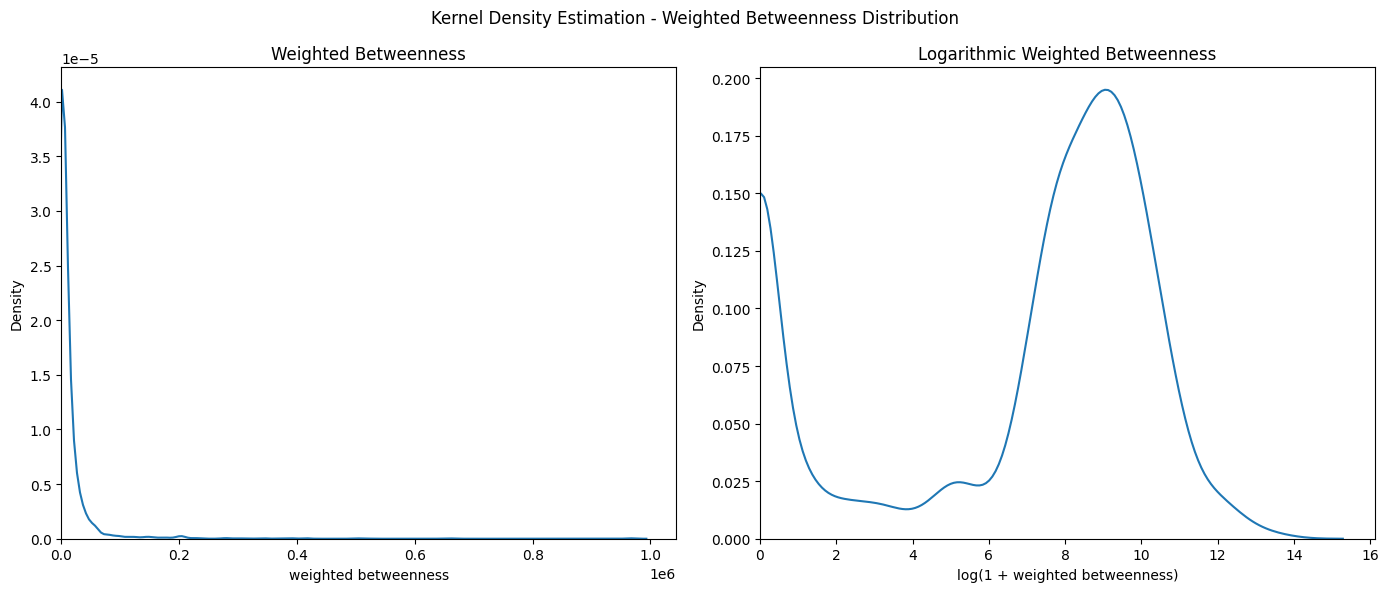

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Kernel Density estimation - weighted betweenness distribution".title())
# KDE plot
sns.kdeplot(df["weighted_betweenness"], ax=axes[0])
axes[0].set_title("Weighted betweenness".title())
axes[0].set_xlabel("weighted betweenness")
axes[0].set_xlim(left=0)

# Logarithmic KDE plot
sns.kdeplot(np.log1p(df["weighted_betweenness"]), ax=axes[1])
axes[1].set_title("Logarithmic weighted betweenness".title())
axes[1].set_xlabel("log(1 + weighted betweenness)")
axes[1].set_xlim(left=0)

plt.tight_layout()
plt.savefig(dir_config.graph_dir / "weighted_betweenness_distribution.png")
plt.show()

In [23]:
df["weighted_betweenness_is_zero"] = np.where(
    df["weighted_betweenness"] == 0, "zero", "non-zero"
)
df["weighted_betweenness_is_zero"].value_counts(normalize=True).round(2)

weighted_betweenness_is_zero
non-zero    0.82
zero        0.18
Name: proportion, dtype: float64

The weighted betweenness seems to be a lot closer to log-normal.

Considering the `log(1+x)`, there is one mode at 0 and another around 9.

About 82 percent of observations are non-zero

In [24]:
# Looking at the cross-tabulation of the dependent and independent variables
pd.crosstab(df["weighted_betweenness_is_zero"], df["avg_incoming_delay_is_zero"])

avg_incoming_delay_is_zero,non-zero,zero
weighted_betweenness_is_zero,,
non-zero,22283,435
zero,4586,411


Cross-tabulating the two, we can see that the zeroes are usually not occuring at the same time.

### Descriptive statistics of the control variables


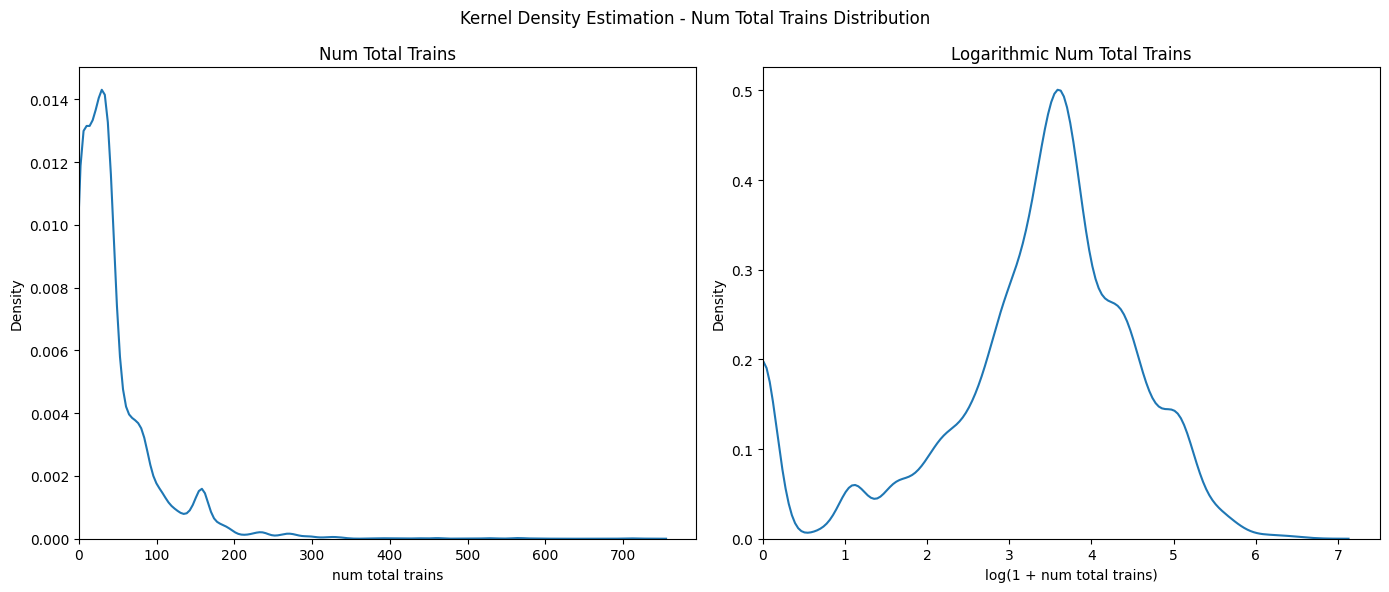

In [25]:
# distribution of num_total_trains
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Kernel Density estimation - num total trains distribution".title())
# KDE plot
sns.kdeplot(df["num_total_trains"].dropna(), ax=axes[0])
axes[0].set_title("Num Total Trains".title())
axes[0].set_xlabel("num total trains")
axes[0].set_xlim(left=0)

# Logarithmic KDE plot
sns.kdeplot(np.log1p(df["num_total_trains"]).dropna(), ax=axes[1])
axes[1].set_title("Logarithmic Num Total Trains".title())
axes[1].set_xlabel("log(1 + num total trains)")
axes[1].set_xlim(left=0)

plt.tight_layout()
plt.savefig(dir_config.graph_dir / "num_total_trains_distribution.png")
plt.show()

In [26]:
# distribution of day of week
pd.DataFrame(df["day_of_week_name"].value_counts(normalize=True).round(2))

,proportion
day_of_week_name,
Thursday,0.17
Wednesday,0.17
Friday,0.13
Saturday,0.13
Monday,0.13
Sunday,0.13
Tuesday,0.13


In [27]:
# creating logaritmic variable for weightedbetweenness, avg_incoming_delay and num_total_trains
# log(1 + weighted_betweenness)
df["log_weighted_betweenness"] = np.log1p(df["weighted_betweenness"])
df["log_avg_incoming_delay"] = np.log1p(df["avg_incoming_delay"])
df["log_num_total_trains"] = np.log1p(df["num_total_trains"])

In [28]:
# parirwise correlation
df[
    ["log_avg_incoming_delay", "log_weighted_betweenness", "log_num_total_trains"]
].corr()

,log_avg_incoming_delay,log_weighted_betweenness,log_num_total_trains
log_avg_incoming_delay,1.000000,0.163044,-0.105066
log_weighted_betweenness,0.163044,1.000000,-0.056056
log_num_total_trains,-0.105066,-0.056056,1.000000


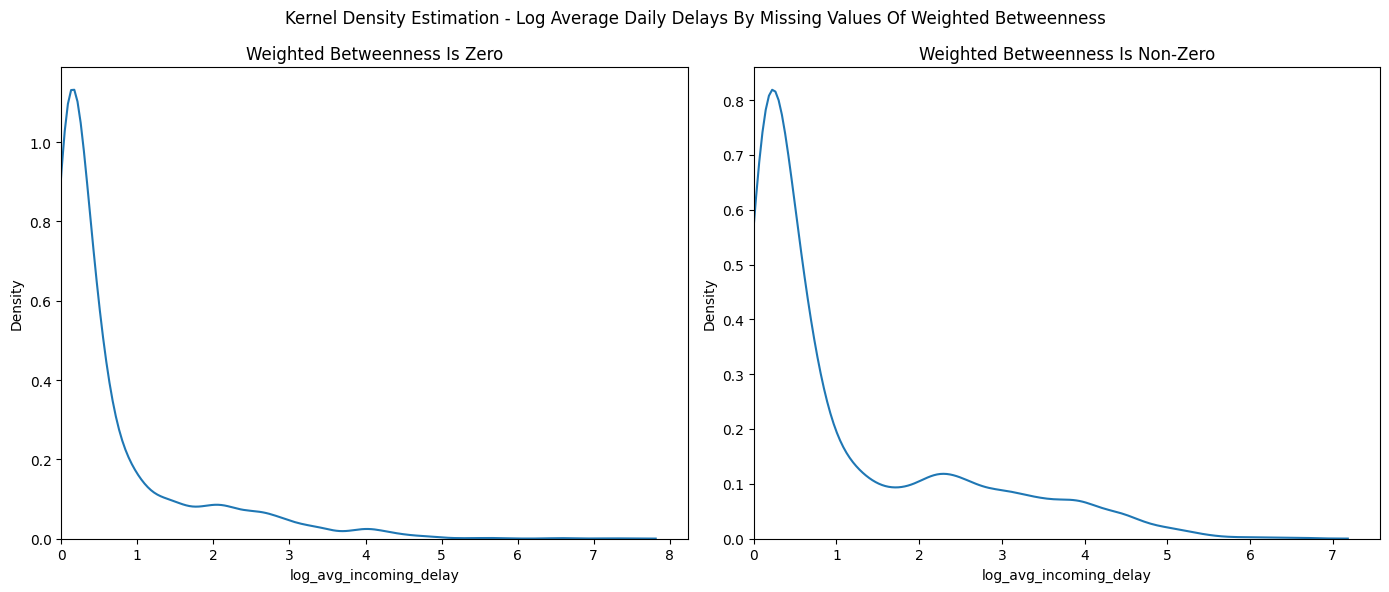

In [30]:
# Distribution of the log_avg_incoming_delay by missing values of the log_weighted_betweenness
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(
    "Kernel Density estimation - log average daily delays by missing values of weighted betweenness".title()
)
# KDE plot
sns.kdeplot(
    df[df["weighted_betweenness"] == 0]["log_avg_incoming_delay"].dropna(), ax=axes[0]
)
axes[0].set_title("Weighted Betweenness is Zero".title())
axes[0].set_xlabel("log_avg_incoming_delay")
axes[0].set_xlim(left=0)

# Logarithmic KDE plot
sns.kdeplot(
    df[df["weighted_betweenness"] != 0]["log_avg_incoming_delay"].dropna(), ax=axes[1]
)
axes[1].set_title("Weighted Betweenness is Non-Zero".title())
axes[1].set_xlabel("log_avg_incoming_delay")
axes[1].set_xlim(left=0)

plt.tight_layout()
plt.savefig(
    dir_config.graph_dir / "log_avg_incoming_delay_by_missing_weighted_betweenness.png"
)
plt.show()

The distribution's right tail seems to be stronger when the main dependent variable is not zero.
This means there is greater variance, which is good for regression.

In [31]:
# Minimal OLS regression
reg1 = smf.ols(
    "log_avg_incoming_delay ~ log_weighted_betweenness + log_num_total_trains",
    data=df,
).fit(cov_type="HC1")
print(reg1.summary())

                              OLS Regression Results                              
Dep. Variable:     log_avg_incoming_delay   R-squared:                       0.033
Model:                                OLS   Adj. R-squared:                  0.033
Method:                     Least Squares   F-statistic:                     331.9
Date:                    Sun, 05 Jan 2025   Prob (F-statistic):          4.62e-142
Time:                            02:31:29   Log-Likelihood:                -27237.
No. Observations:                   16697   AIC:                         5.448e+04
Df Residuals:                       16694   BIC:                         5.450e+04
Df Model:                               2                                         
Covariance Type:                      HC1                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [32]:
# adding day of week as control variable
reg2 = smf.ols(
    "log_avg_incoming_delay ~ log_weighted_betweenness + log_num_total_trains + day_of_week_name",
    data=df,
).fit(cov_type="HC1")
print(reg2.summary())

                              OLS Regression Results                              
Dep. Variable:     log_avg_incoming_delay   R-squared:                       0.037
Model:                                OLS   Adj. R-squared:                  0.036
Method:                     Least Squares   F-statistic:                     88.28
Date:                    Sun, 05 Jan 2025   Prob (F-statistic):          4.18e-144
Time:                            02:31:34   Log-Likelihood:                -27205.
No. Observations:                   16697   AIC:                         5.443e+04
Df Residuals:                       16688   BIC:                         5.450e+04
Df Model:                               8                                         
Covariance Type:                      HC1                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

In [33]:
# interacting date with the weighted betweenness
reg3 = smf.ols(
    "log_avg_incoming_delay ~ log_weighted_betweenness * day_of_week_name + log_num_total_trains",
    data=df,
).fit(cov_type="HC1")
print(reg3.summary())

                              OLS Regression Results                              
Dep. Variable:     log_avg_incoming_delay   R-squared:                       0.038
Model:                                OLS   Adj. R-squared:                  0.037
Method:                     Least Squares   F-statistic:                     51.24
Date:                    Sun, 05 Jan 2025   Prob (F-statistic):          6.95e-141
Time:                            02:31:37   Log-Likelihood:                -27195.
No. Observations:                   16697   AIC:                         5.442e+04
Df Residuals:                       16682   BIC:                         5.454e+04
Df Model:                              14                                         
Covariance Type:                      HC1                                         
                                                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

In [34]:
# plot predicted daily average delays for each day of the week by the weighted betweenness
pred = (
    reg3.get_prediction(df.sort_values("log_weighted_betweenness"))
    .summary_frame()[["mean", "mean_ci_lower", "mean_ci_upper"]]
    .rename(
        columns={
            "mean": "predicted_avg_incoming_delay",
            "mean_ci_lower": "lower_bound",
            "mean_ci_upper": "upper_bound",
        }
    )
)


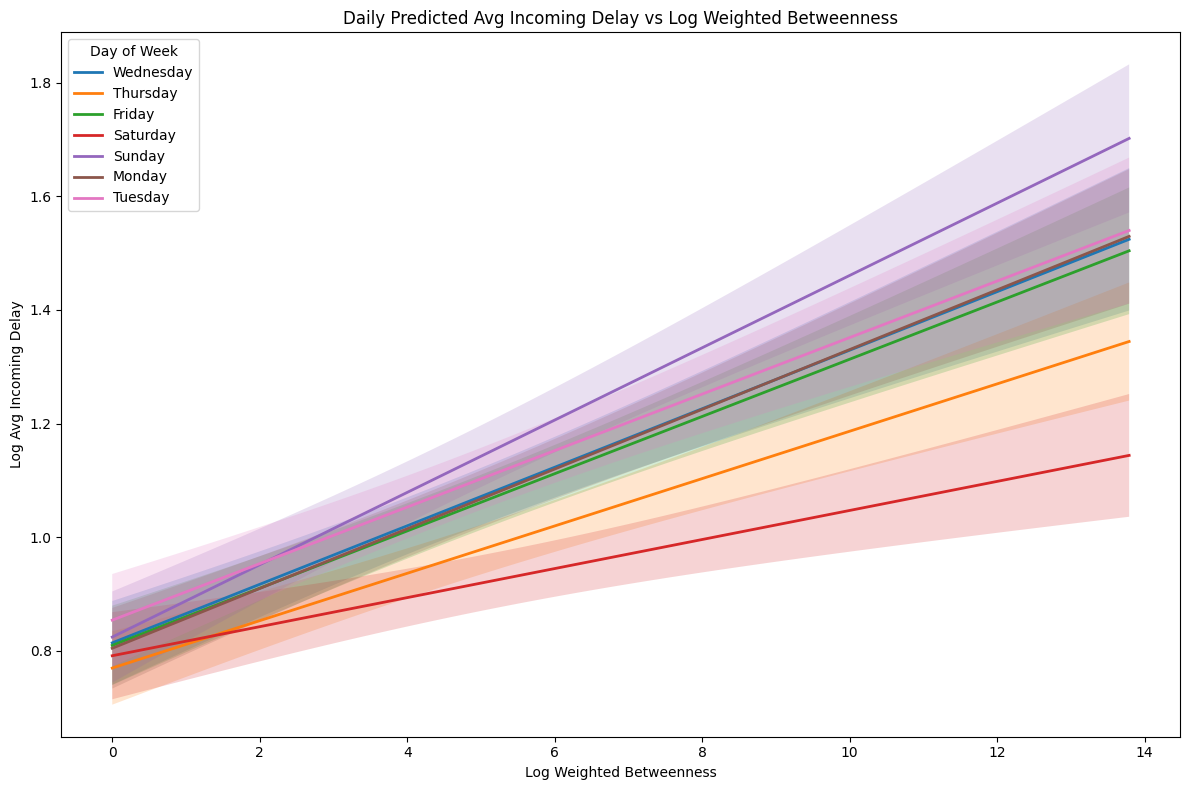

In [35]:
# Generate a smooth range of values for log_weighted_betweenness
log_weighted_betweenness_range = np.linspace(
    df["log_weighted_betweenness"].min(),
    df["log_weighted_betweenness"].max(),
    1000,  # Increase the number for smoother lines
)

# Prepare an empty DataFrame to store predictions
predictions_all = pd.DataFrame()

# Get unique days of the week
unique_days = df["day_of_week_name"].unique()

for day in unique_days:
    # Create a DataFrame for predictions
    prediction_df = pd.DataFrame(
        {
            "log_weighted_betweenness": log_weighted_betweenness_range,
            "day_of_week_name": day,
            "log_num_total_trains": df[
                "log_num_total_trains"
            ].mean(),  # Use mean or other representative value
        }
    )

    # Get predictions
    predictions = reg3.get_prediction(prediction_df).summary_frame()
    prediction_df["predicted_avg_incoming_delay"] = predictions["mean"]
    prediction_df["lower_bound"] = predictions["mean_ci_lower"]
    prediction_df["upper_bound"] = predictions["mean_ci_upper"]

    # Append to the main DataFrame
    predictions_all = pd.concat([predictions_all, prediction_df], ignore_index=True)

# Plot with Seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=predictions_all,
    x="log_weighted_betweenness",
    y="predicted_avg_incoming_delay",
    hue="day_of_week_name",
    palette="tab10",
    linewidth=2,
)

# Add confidence intervals with fill_between
for day in unique_days:
    day_data = predictions_all[predictions_all["day_of_week_name"] == day]
    plt.fill_between(
        day_data["log_weighted_betweenness"],
        day_data["lower_bound"],
        day_data["upper_bound"],
        alpha=0.2,
        label=None,
    )

# Customize the plot
plt.xlabel("Log Weighted Betweenness")
plt.ylabel("Log Avg Incoming Delay")
plt.title("Daily Predicted Avg Incoming Delay vs Log Weighted Betweenness")
plt.legend(title="Day of Week")
plt.tight_layout()
plt.show()

In [42]:
# stargazer table
stargazer = Stargazer([reg1, reg2, reg3])
stargazer.title("Table 1: OLS Regressions")
stargazer.custom_columns(["Model 1", "Model 2", "Model 3"], [1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.show_degrees_of_freedom(False)
# reorder covariates of dates to be in the same order as the day of week names
stargazer.covariate_order(
    [
        "Intercept",
        "log_weighted_betweenness",
        "log_num_total_trains",
        "day_of_week_name[T.Monday]",
        "day_of_week_name[T.Tuesday]",
        "day_of_week_name[T.Wednesday]",
        "day_of_week_name[T.Thursday]",
        # "day_of_week_name[T.Friday]",
        "day_of_week_name[T.Saturday]",
        "day_of_week_name[T.Sunday]",
        "log_weighted_betweenness:day_of_week_name[T.Monday]",
        "log_weighted_betweenness:day_of_week_name[T.Tuesday]",
        "log_weighted_betweenness:day_of_week_name[T.Wednesday]",
        "log_weighted_betweenness:day_of_week_name[T.Thursday]",
        # "log_weighted_betweenness:day_of_week_name[T.Friday]",
        "log_weighted_betweenness:day_of_week_name[T.Saturday]",
        "log_weighted_betweenness:day_of_week_name[T.Sunday]",
    ]
)

# rename day of week names
stargazer.rename_covariates(
    {
        "Intercept": "Intercept",
        "log_weighted_betweenness": "Log Weighted Betweenness",
        "log_num_total_trains": "Log Num Total Trains",
        "day_of_week_name[T.Monday]": "Monday",
        "day_of_week_name[T.Tuesday]": "Tuesday",
        "day_of_week_name[T.Wednesday]": "Wednesday",
        "day_of_week_name[T.Thursday]": "Thursday",
        "day_of_week_name[T.Friday]": "Friday",
        "day_of_week_name[T.Saturday]": "Saturday",
        "day_of_week_name[T.Sunday]": "Sunday",
        "log_weighted_betweenness:day_of_week_name[T.Monday]": "Log Weighted Betweenness x Monday",
        "log_weighted_betweenness:day_of_week_name[T.Tuesday]": "Log Weighted Betweenness x Tuesday",
        "log_weighted_betweenness:day_of_week_name[T.Wednesday]": "Log Weighted Betweenness x Wednesday",
        "log_weighted_betweenness:day_of_week_name[T.Thursday]": "Log Weighted Betweenness x Thursday",
        "log_weighted_betweenness:day_of_week_name[T.Friday]": "Log Weighted Betweenness x Friday",
        "log_weighted_betweenness:day_of_week_name[T.Saturday]": "Log Weighted Betweenness x Saturday",
        "log_weighted_betweenness:day_of_week_name[T.Sunday]": "Log Weighted Betweenness x Sunday",
    }
)

# save the table to a file
with open(dir_config.table_dir / "regression_table.html", "w") as f:
    f.write(stargazer.render_html())

stargazer

In [ ]:
# TODO: Add more control variables
# total distance, total times, total speed, average delay of neighbors, christmas period dummy
# interaction between christmas period and log_weighted_betweenness and plot the predicted values against each other.